### CNN classifier

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transform


class Network(nn.Module):
    def __init__(self, channels=1): # default grayscale
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=6, kernel_size=5) 
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120) # ((28-5+1)/2 -5 +1)/2 = 4
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t = t
        
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t) # activation_function='relu' in tf.keras      
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t) # activation_funcion='relu' in tf.keras
        
        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        
        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1) # first index is batch
        return t


def get_num_correct(preds, labels):
    return (preds.argmax(dim=1) == labels).sum()


# Get data
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    download=False,
    transform=transform.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)


# Compile network
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.01)


# Train for 10 epochs
for epoch in range(10): 
    total_loss = 0
    total_correct = 0
    
    for batch in train_loader:
        images, labels = batch 
        preds = network(images)
        
        loss = F.cross_entropy(preds, labels) # loss function
        optimizer.zero_grad()                 # set all gradients to zero
        
        loss.backward()         # calculate gradients, training points are supply constants
        optimizer.step()        # update weights to minimize loss (accdg to adam)

        total_loss += loss.item() 
        total_correct += get_num_correct(preds, labels)
        
    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

epoch 0 total_correct: tensor(46838) loss: 344.53701773285866
epoch 1 total_correct: tensor(50945) loss: 244.01069650053978
epoch 2 total_correct: tensor(51832) loss: 219.10231386125088
epoch 3 total_correct: tensor(52202) loss: 208.02306815981865
epoch 4 total_correct: tensor(52510) loss: 202.58269038796425
epoch 5 total_correct: tensor(52716) loss: 196.518198043108
epoch 6 total_correct: tensor(52934) loss: 191.21221677213907
epoch 7 total_correct: tensor(53007) loss: 188.66794322431087
epoch 8 total_correct: tensor(53041) loss: 186.9791361093521
epoch 9 total_correct: tensor(53135) loss: 187.05346062779427


### Getting all labels and all predictions

In [0]:
@torch.no_grad()
def get_all_preds_labels(model, loader): # simple concat
    all_preds  = torch.tensor([])
    all_labels = torch.tensor([])
    for batch in loader:
        images, labels = batch
        all_preds  = torch.cat((all_preds,  model(images)),  dim=0)
        all_labels = torch.cat((all_labels, labels.float()), dim=0)
    return all_preds, all_labels


with torch.no_grad(): # disable gradient tracking!
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=60000)
    train_preds, train_labels = get_all_preds_labels(network, train_loader)

In [0]:
train_preds.shape # predictions in the form of probability dists

torch.Size([60000, 10])

In [0]:
train_labels.shape

torch.Size([60000])

In [0]:
train_preds.argmax(dim=1).shape

torch.Size([60000])

### Calculating the confusion matrix

Confusion matrix $C_{ij}$ is the number of examples that with label $i$ but predicted $j$. Thus the confusion matrix in our example is a 10 $\times$ 10 matrix.

In [0]:
import numpy as np

# grok
def confusion_matrix(y_true, y_pred):
    C = np.zeros((10, 10), dtype=int)
    for k in range(len(y_true)):
        i = actual[k]   
        j = predicted[k]
        C[i, j] += 1
    return C

In [0]:
actual    = train_labels.int().numpy()
predicted = train_preds.argmax(dim=1).int().numpy()

In [0]:
import sklearn
(confusion_matrix(actual, predicted) == 
 sklearn.metrics.confusion_matrix(actual, predicted)).all()

True

In [0]:
C = confusion_matrix(actual, predicted)

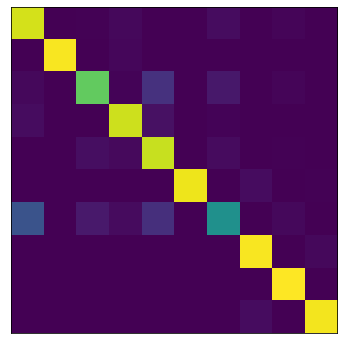

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# simple man plot
plt.figure(figsize=(6,6))
plt.imshow(C)
plt.xticks([])
plt.yticks([]);

In [0]:
np.array(C/60, dtype=int)

array([[92,  0,  0,  2,  0,  0,  3,  0,  1,  0],
       [ 0, 97,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 2,  0, 74,  1, 14,  0,  6,  0,  1,  0],
       [ 3,  0,  0, 90,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  2, 90,  0,  2,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 95,  0,  3,  0,  0],
       [25,  0,  6,  2, 13,  0, 49,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 97,  0,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 98,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  0, 96]])

Shirts are being confused as tops. (Understandably so.)

Confusion matrix, without normalization
[[5526   14   45  125   18    4  189    0   77    2]
 [   7 5854    3  112   10    3    5    1    4    1]
 [ 125    8 4483   67  848    4  386    0   79    0]
 [ 187   15   11 5453  262    1   55    1   14    1]
 [  12    9  208  149 5411    1  174    1   33    2]
 [   1    0    0    1    0 5758    0  191    9   40]
 [1520   15  406  171  799    4 2964    0  121    0]
 [   0    0    0    0    0   21    0 5841    5  133]
 [  19    2    5   19   19   10   15    7 5903    1]
 [   0    0    0    0    0   17    0  192    1 5790]]


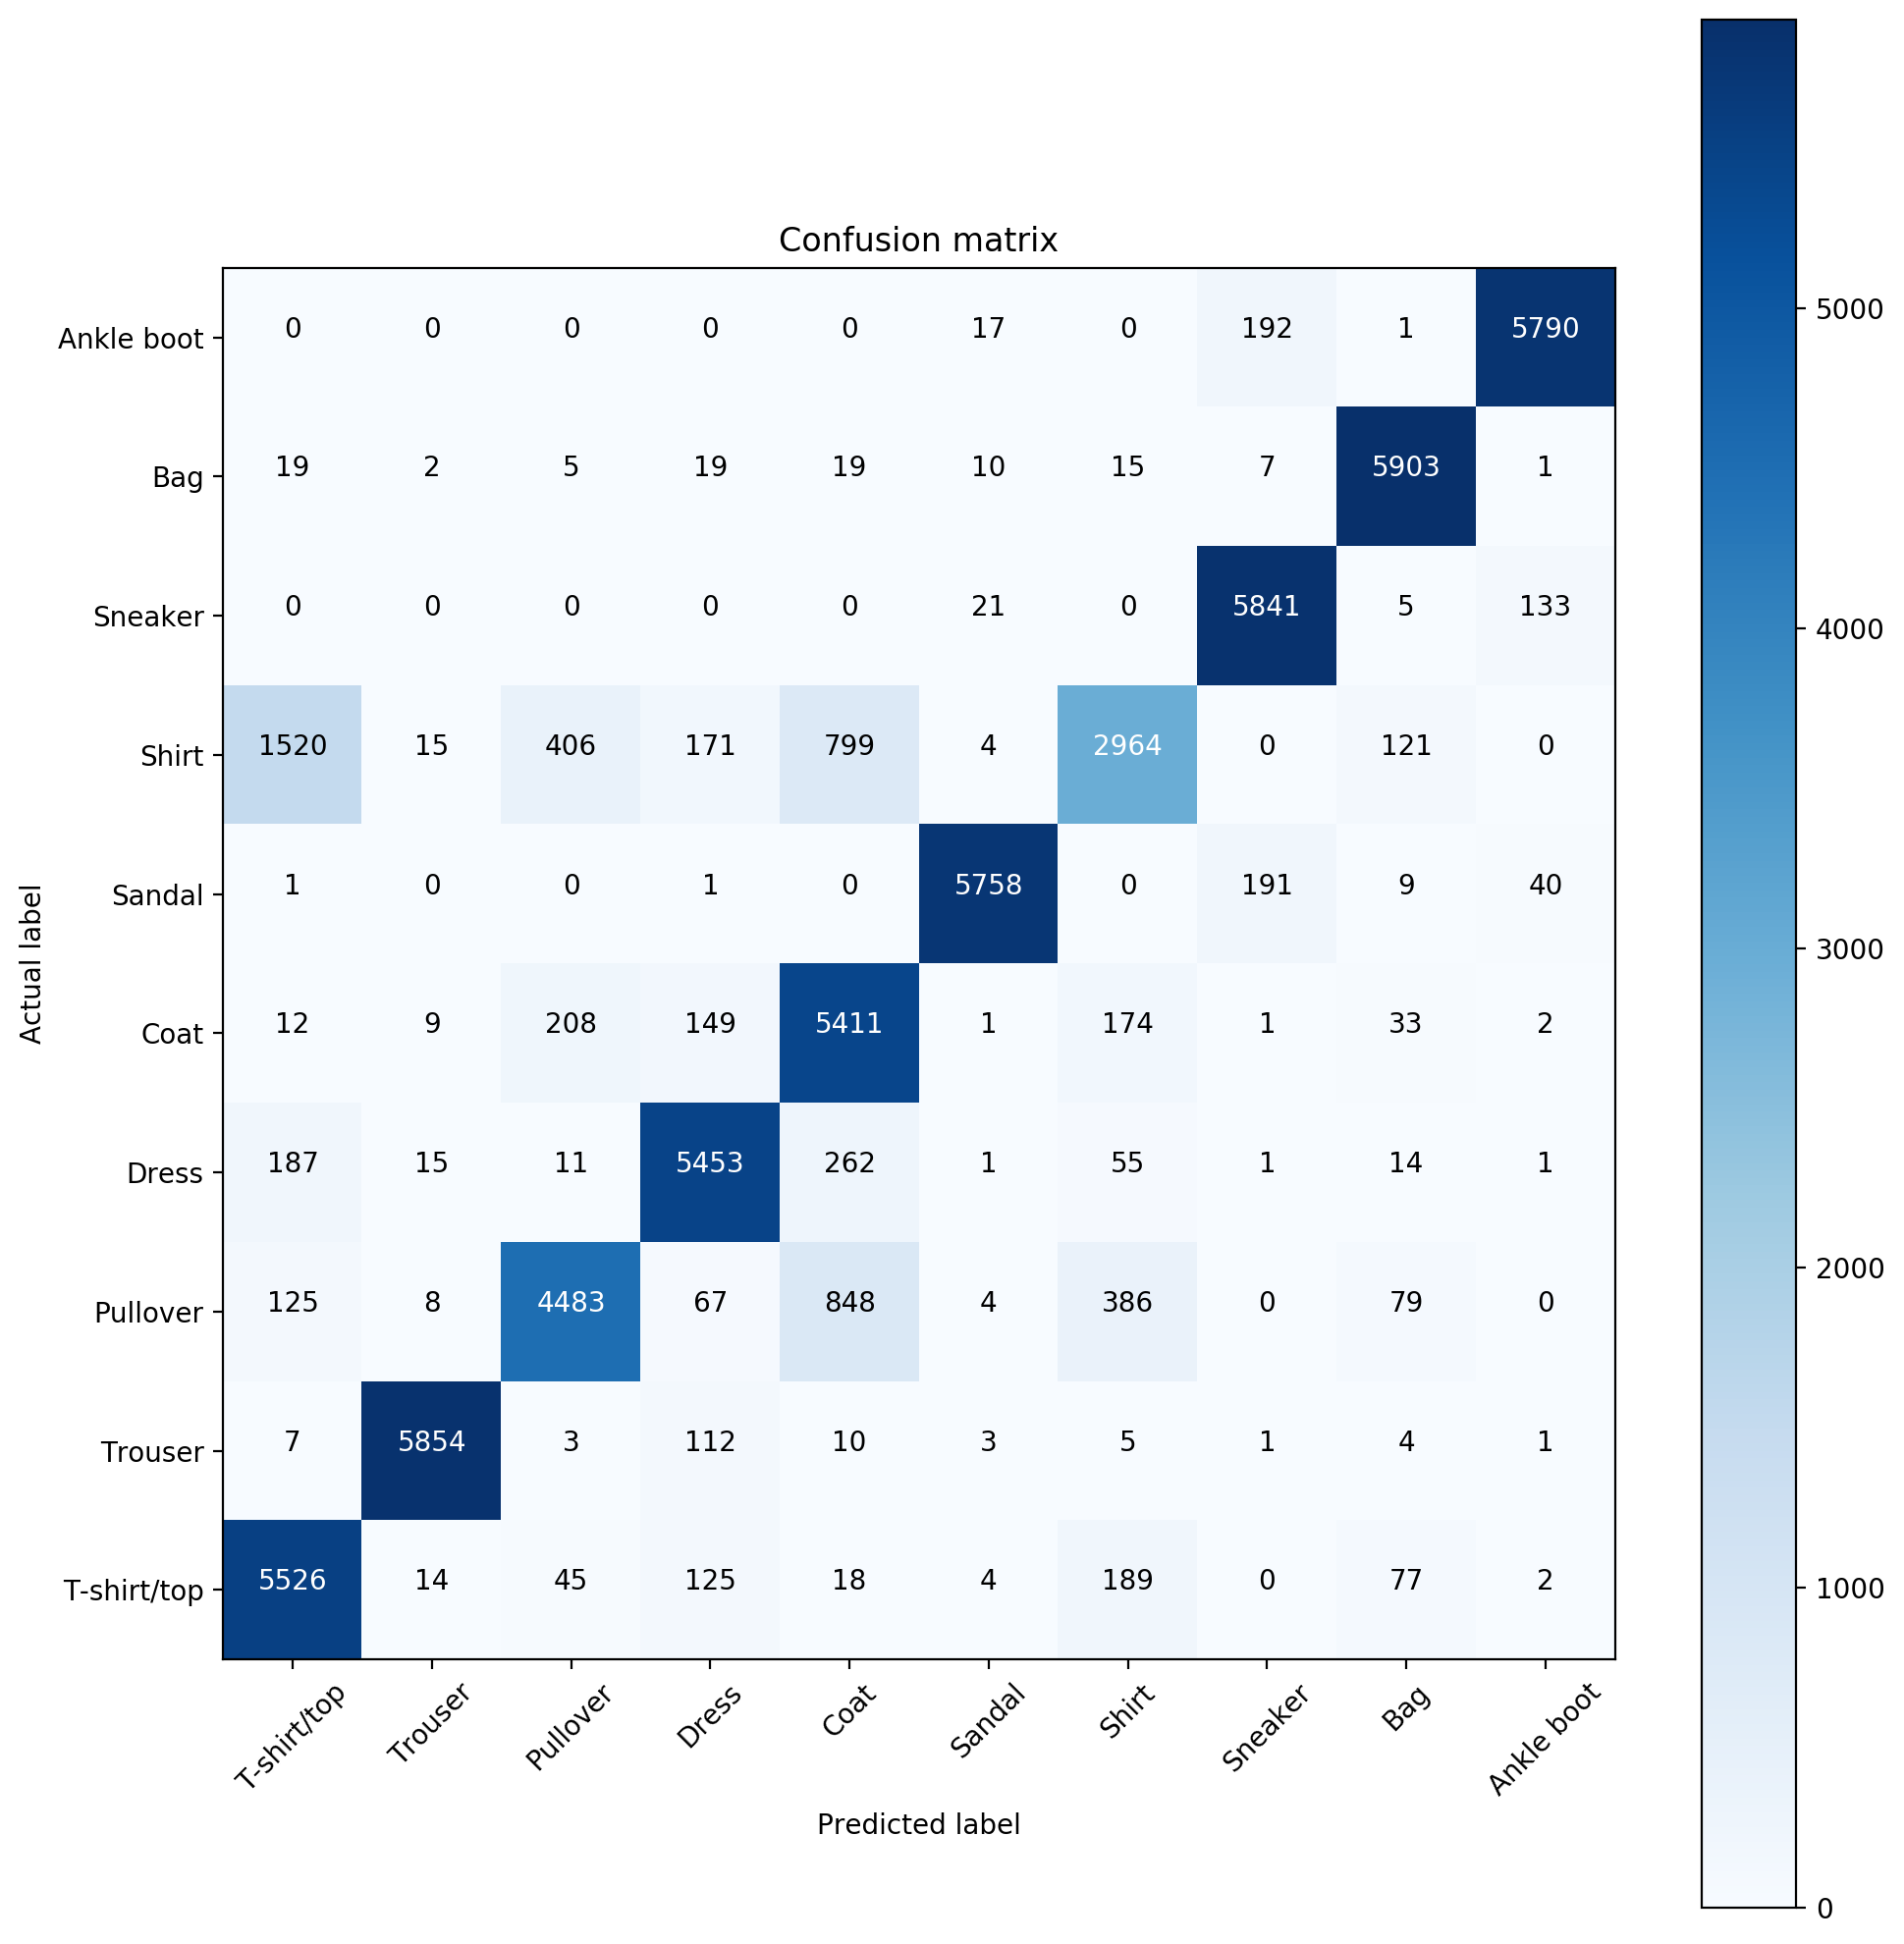

In [0]:
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import seaborn as sns


def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
    
    # print the cm
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    # plot the cm
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd' # float or int
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black") # color of text

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plt.figure(figsize=(10,10), dpi=200)
plot_confusion_matrix(C, names)
if matplotlib.__version__ == '3.1.1':
    axes = plt.gca()
    a = axes.get_ylim()
    plt.ylim(a[1]-0.5, a[0]+0.5)

matplotlib 3.1.1 broke seaborn heatmap.

In [0]:
matplotlib.__version__

'3.1.1'